In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

c:\python38\lib\site-packages\torch\cuda\__init__.py:749: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


In [2]:
train_dir = "KneeData/MedicalExpert-I"
test_dir = "KneeData/MedicalExpert-II"

In [3]:
# Data transforms (resize all images, normalize to ImageNet mean/std)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [4]:
# Load datasets

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

In [5]:
num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)

Classes: ['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']


In [6]:
def get_model(model_name="resnet18", num_classes=4, finetune=False):
    if model_name == "resnet18":
        model = models.resnet18(weights="IMAGENET1K_V1")
    elif model_name == "resnet50":
        model = models.resnet50(weights="IMAGENET1K_V1")
    else:
        raise ValueError("Only resnet18 or resnet50 supported")

    # Replace final layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    # Feature extractor mode (only train classifier)
    if not finetune:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

    return model


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cpu


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Training Resnet50 model for 10 epochs

In [9]:
model = get_model("resnet50", num_classes=num_classes, finetune=False)  
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {acc:.2f}%")


Epoch [1/10], Loss: 1.5289, Accuracy: 31.82%
Epoch [2/10], Loss: 1.4223, Accuracy: 39.76%
Epoch [3/10], Loss: 1.3540, Accuracy: 41.33%
Epoch [4/10], Loss: 1.3024, Accuracy: 46.42%
Epoch [5/10], Loss: 1.2502, Accuracy: 49.94%
Epoch [6/10], Loss: 1.2264, Accuracy: 50.91%
Epoch [7/10], Loss: 1.1972, Accuracy: 51.52%
Epoch [8/10], Loss: 1.1775, Accuracy: 52.85%
Epoch [9/10], Loss: 1.1426, Accuracy: 54.30%
Epoch [10/10], Loss: 1.1330, Accuracy: 54.12%


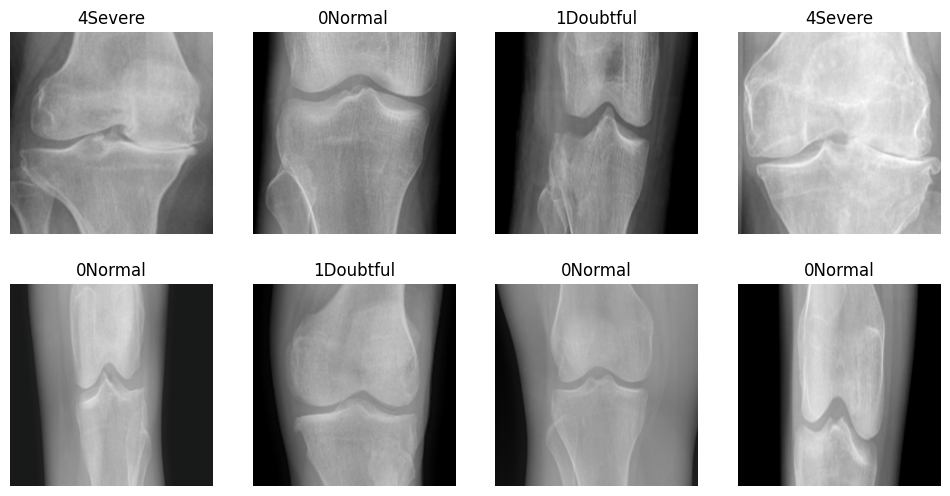

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and show image
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))   # CxHxW -> HxWxC
    mean = np.array([0.485, 0.456, 0.406])   # ImageNet mean
    std = np.array([0.229, 0.224, 0.225])    # ImageNet std
    img = std * img + mean                   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis("off")

# Get a batch from train_loader
images, labels = next(iter(train_loader))

# Show first 8 images
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    imshow(images[i], title=train_dataset.classes[labels[i]])
plt.show()


In [11]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 57.45%


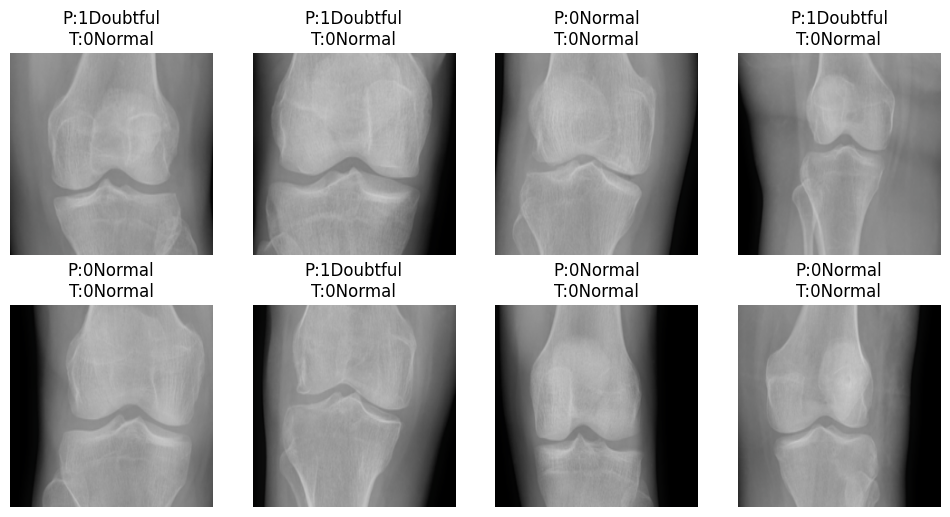

In [13]:
# Grab a few test images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Predict
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Show 8 images with predicted vs. true labels
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    imshow(images[i].cpu(), title=f"P:{test_dataset.classes[preds[i]]}\nT:{test_dataset.classes[labels[i]]}")
plt.show()


In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


<Figure size 1200x1200 with 0 Axes>

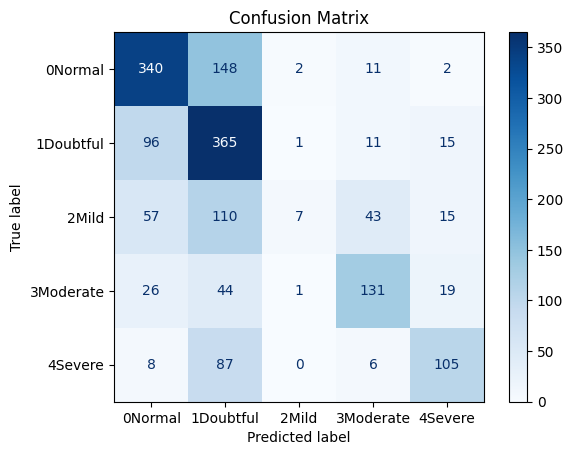

In [15]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)


plt.figure(figsize=(12, 12))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()
